# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Variogram" data-toc-modified-id="Variogram-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Variogram</a></div><div class="lev1 toc-item"><a href="#Grid-variogram" data-toc-modified-id="Grid-variogram-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grid variogram</a></div>

Our spatial model doesn't seem to be powerful enough. I suspect we're underestimating spatial correlations. Let's compare the covariance function of our model to empirical correlations between the 4 stations in Iowa.

In [1]:
using TimeSeries
using DataFrames
using DataFrames: head, groupby
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using Dates
using StatsBase
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
include("src/preprocessing.jl")

test_data (generic function with 1 method)

In [4]:
isdList=read_isdList()
isdList[1:5,:]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,10010,99999,JAN MAYEN(NOR-NAVY),NO,,ENJA,70.933,-8.667,9.0,1931,2015,4.5545e6,6.11344e6
2,10060,99999,EDGEOYA,NO,,,78.25,22.817,14.0,1973,2015,4.04982e6,7.5564e6
3,10070,99999,NY-ALESUND,SV,,,78.917,11.933,7.7,1973,2015,3.8678e6,7.26549e6
4,10080,99999,LONGYEAR,SV,,ENSB,78.246,15.466,26.8,1975,2015,3.99705e6,7.33669e6
5,10090,99999,KARL XII OYA,SV,,,80.65,25.0,5.0,1955,2015,3.69259e6,7.68545e6


In [5]:
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
numstations=nrow(isdSubset)
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [6]:
hourly_cat=read_Stations(isdSubset)
hourly_cat[1:5,:]

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.86667


In [7]:
ts = hourly_cat[:ts].values
ts_bins = collect(minimum(ts):Hour(1):maximum(ts))
ts_bins[1:5]

5-element Array{DateTime,1}:
 2015-01-01T00:00:00
 2015-01-01T01:00:00
 2015-01-01T02:00:00
 2015-01-01T03:00:00
 2015-01-01T04:00:00

In [8]:
hourly_cat[:hour] = [round(dt, Dates.Hour) for dt in ts]
head(hourly_cat)

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,2015-01-01T01:00:00,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,2015-01-01T02:00:00,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2015-01-01T03:00:00,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,2015-01-01T04:00:00,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,2015-01-01T05:00:00,52,0,-9.4,2015-01-01T04:52:00,1,4.86667
6,2015,1,1,2015-01-01T06:00:00,52,0,-10.0,2015-01-01T05:52:00,1,5.86667


# Variogram

In [9]:
sqdiff_accum = zeros(Float64, numstations, numstations)
npairs = zeros(Int, numstations, numstations)
by_hour = groupby(hourly_cat, :hour)
for simult in by_hour
    for i in 1:nrow(simult)
        for j in 1:i-1
            station_i = get(simult[i,:station])
            station_j = get(simult[j,:station])

            temp_i = get(simult[i,:temp])
            temp_j = get(simult[j,:temp])

            sqdiff_accum[station_i,station_j] += (temp_i-temp_j)^2
            sqdiff_accum[station_j,station_i] += (temp_i-temp_j)^2
            npairs[station_i,station_j] += 1
            npairs[station_j,station_i] += 1
        end
    end
end

In [10]:
vargrid = sqdiff_accum ./ (npairs.*2)

4×4 Array{Float64,2}:
 0.191261  4.43257   1.868     4.99088 
 4.43257   0.142557  4.96368   7.68208 
 1.868     4.96368   0.174391  2.05267 
 4.99088   7.68208   2.05267   0.163581

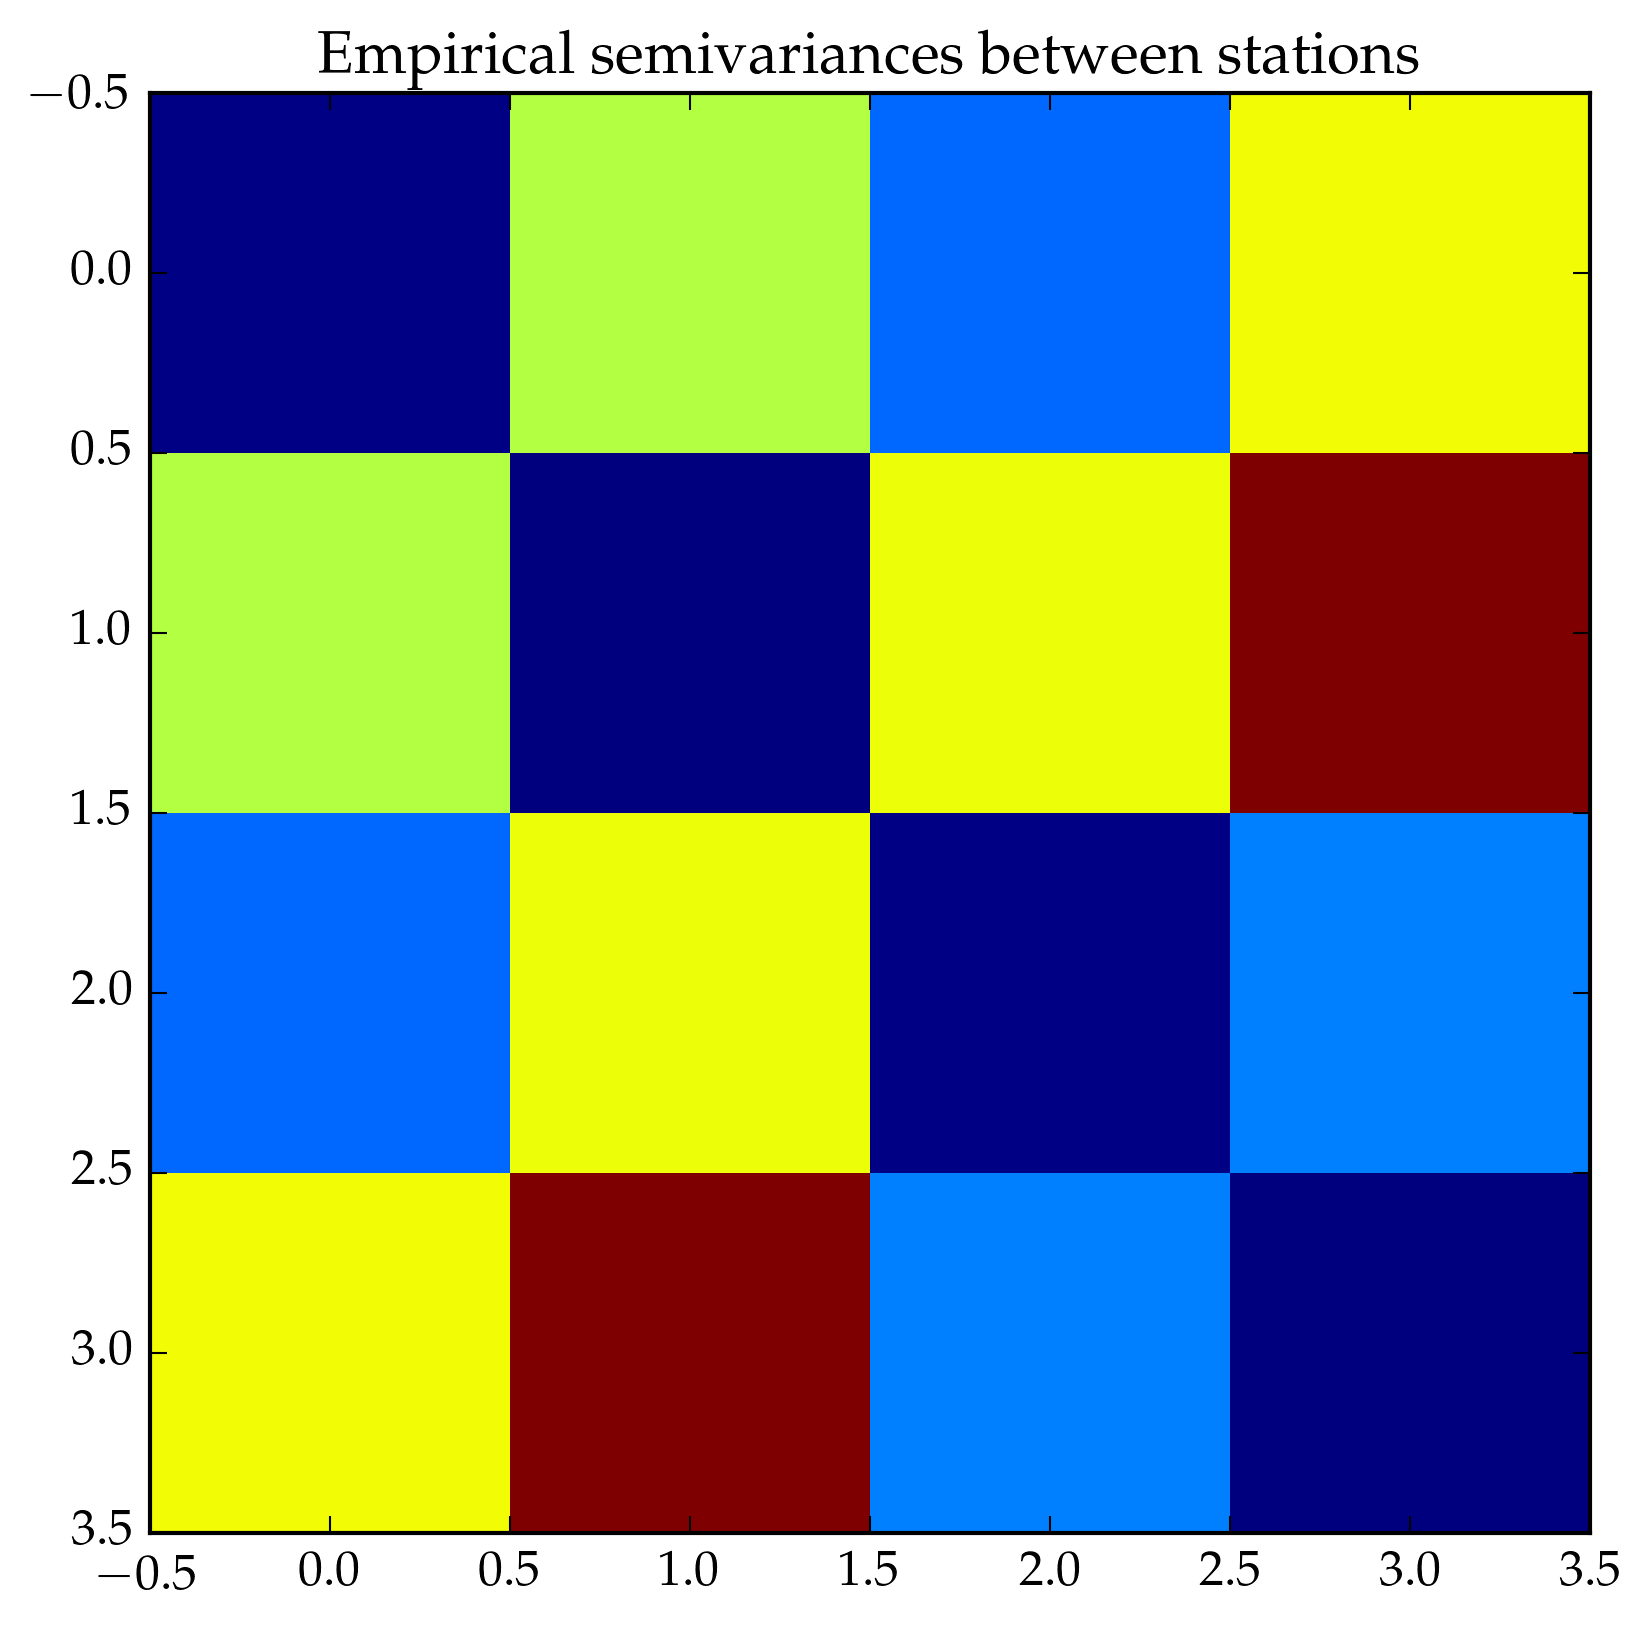

PyObject <matplotlib.text.Text object at 0x31a0baa90>

In [11]:
plt.imshow(vargrid, interpolation="nearest")
plt.title("Empirical semivariances between stations")

Let's plot the empirical semi-variances as a function of the distance between pairs of stations, and compare that to the variogram of our fitted spatiotemporal kernel.

In [12]:
include("src/fitted_kernel.jl")

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  li

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [11.2445,0.132749]


In [13]:
pairwiseEuclid=pairwise(Euclidean(), Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])')

4×4 Array{Float64,2}:
      0.0        165736.0        93510.4        1.93474e5
 165736.0             0.0            1.53559e5  1.81942e5
  93510.4             1.53559e5      0.0        1.00846e5
      1.93474e5       1.81942e5      1.00846e5  0.0      

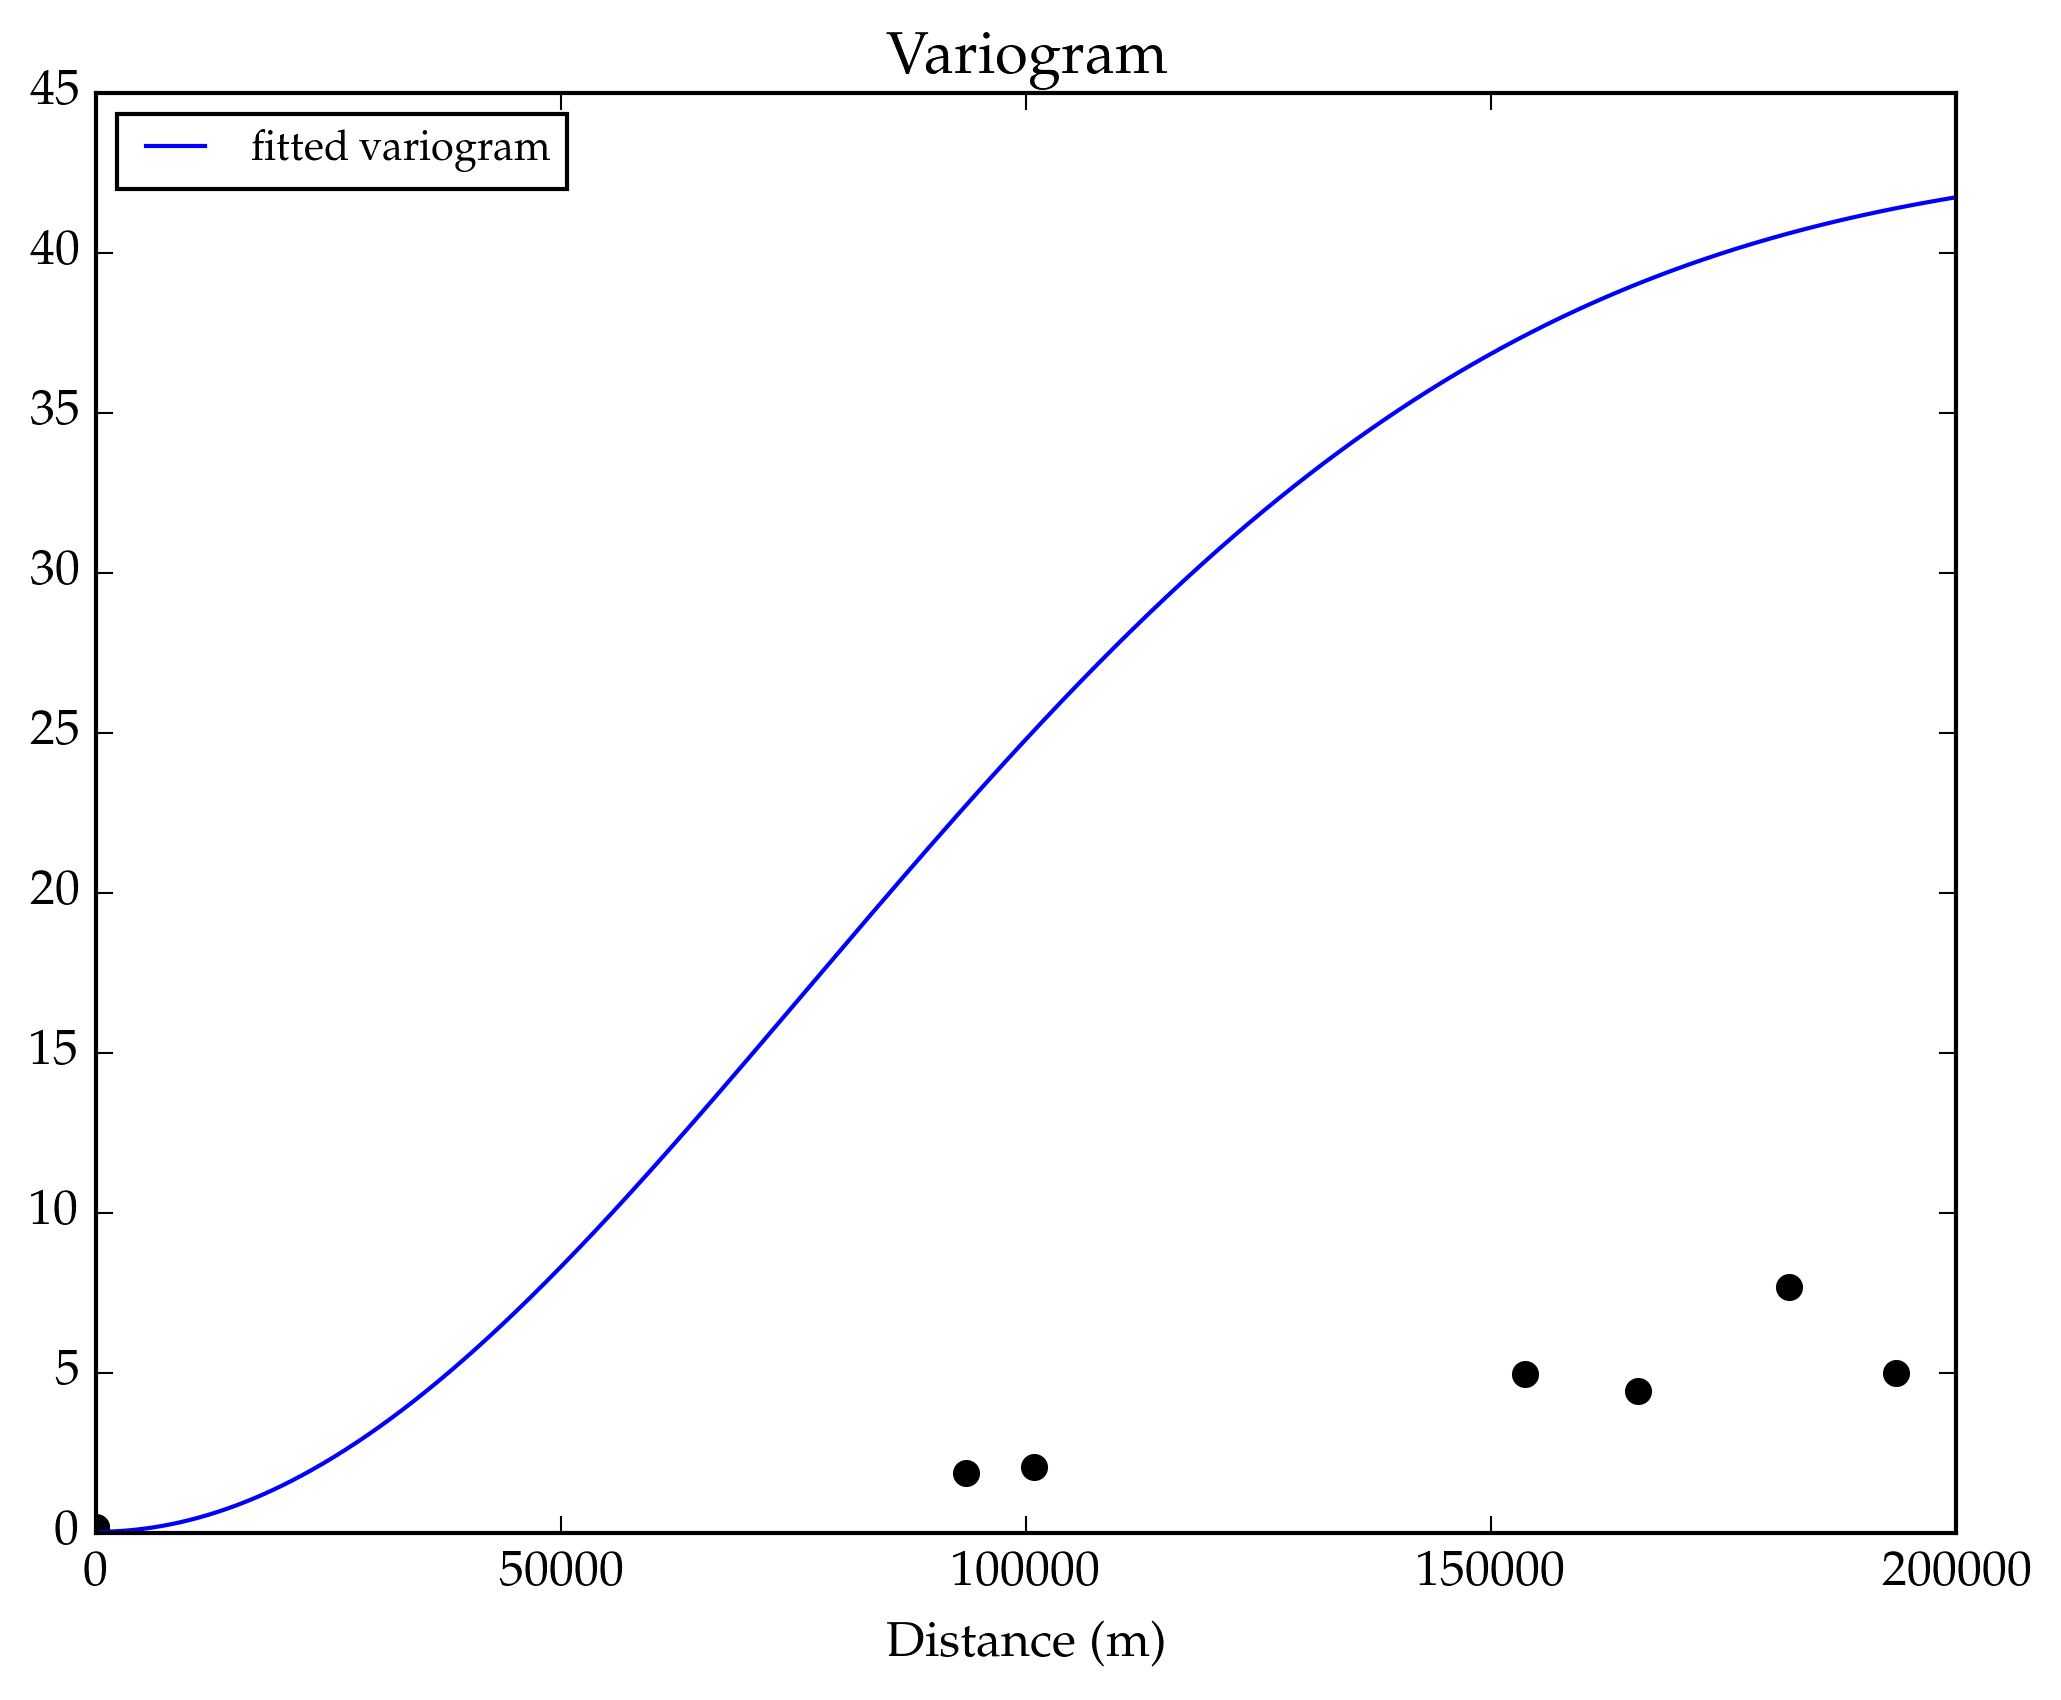

PyObject <matplotlib.legend.Legend object at 0x30cc55a90>

In [14]:
# begin
for i in 1:numstations
    for j in 1:i
        plt.plot(pairwiseEuclid[i,j], vargrid[i,j], "o", color="black")
    end
end
rr = linspace(0.0, 200000.0, 1000)
ck_spt = [cov(k_spatiotemporal, [0.0,r,0.0], [0.0,0.0,0.0]) for r in rr]
plt.plot(rr, exp(2.0*logNoise)+ck_spt[1].-ck_spt, label="fitted variogram")
plt.xlabel("Distance (m)")
plt.title("Variogram")
plt.legend(loc="upper left", fontsize="small")
# end

As I suspected, the kernel is not a good fit for the empirical variogram. Two possible explanations spring to mind:
1. the optimization algorithm of the spatial kernel got stuck in a local maximum (of the marginal likelihood)
2. the product kernel specification is too restrictive, it is forcing the model to underestimate the spatial correlations

# Grid variogram

In [15]:
type Variogram
    bins::AbstractVector
    sqdiff_accum::AbstractVector{Float64}
    npairs::AbstractVector{Int}
    function Variogram(bins::AbstractVector)
        nbins = length(bins)
        sqdiff_accum = zeros(Float64, nbins)
        npairs = zeros(Int, nbins)
        return new(bins, sqdiff_accum, npairs)
    end
end 
variog(v::Variogram) = v.sqdiff_accum ./ (v.npairs.*2)

variog (generic function with 1 method)

In [16]:
timebins=Hour(0):Hour(2):Hour(30*24)
nbins=length(timebins)

361

In [17]:
group_stations = groupby(hourly_cat, :station);

In [18]:
function cross_variog{Vt<:AbstractVector,Vy<:AbstractVector}(times_i::Vt, times_j::Vt, temp_i::Vy, temp_j::Vy, timebins::AbstractVector)
    v = Variogram(timebins)
    for i in 1:length(times_i)
        t_i = times_i[i]
        y_i = temp_i[i]
        for j in 1:length(times_j)
            t_j = times_j[j]
            y_j = temp_j[j]
            timediff = abs(t_j-t_i)
            ibin = searchsortedlast(v.bins, timediff)
            if ibin == length(v.bins)
                continue
            end
            v.sqdiff_accum[ibin] += (y_i-y_j)^2
            v.npairs[ibin] += 1
        end
    end
    return v
end

cross_variog (generic function with 1 method)

In [19]:
function cross_variog(station_i::Int, station_j::Int, timebins::AbstractVector)
    data_i = group_stations[station_i]
    data_j = group_stations[station_j]
    times_i = data_i[:ts].values
    times_j = data_j[:ts].values
    temp_i = data_i[:temp].values
    temp_j = data_j[:temp].values
    return cross_variog(times_i, times_j, temp_i, temp_j, timebins)
end

cross_variog (generic function with 2 methods)

In [20]:
@time v=cross_variog(1,2, timebins);

 23.127652 seconds (241.06 M allocations: 3.595 GB, 1.59% gc time)


In [28]:
all_cross_variogs = Array(Variogram, 4, 4)
for station_i in 1:4
    for station_j in station_i:4
        v=cross_variog(station_i, station_j, timebins)
        all_cross_variogs[station_i, station_j] = v
    end
end

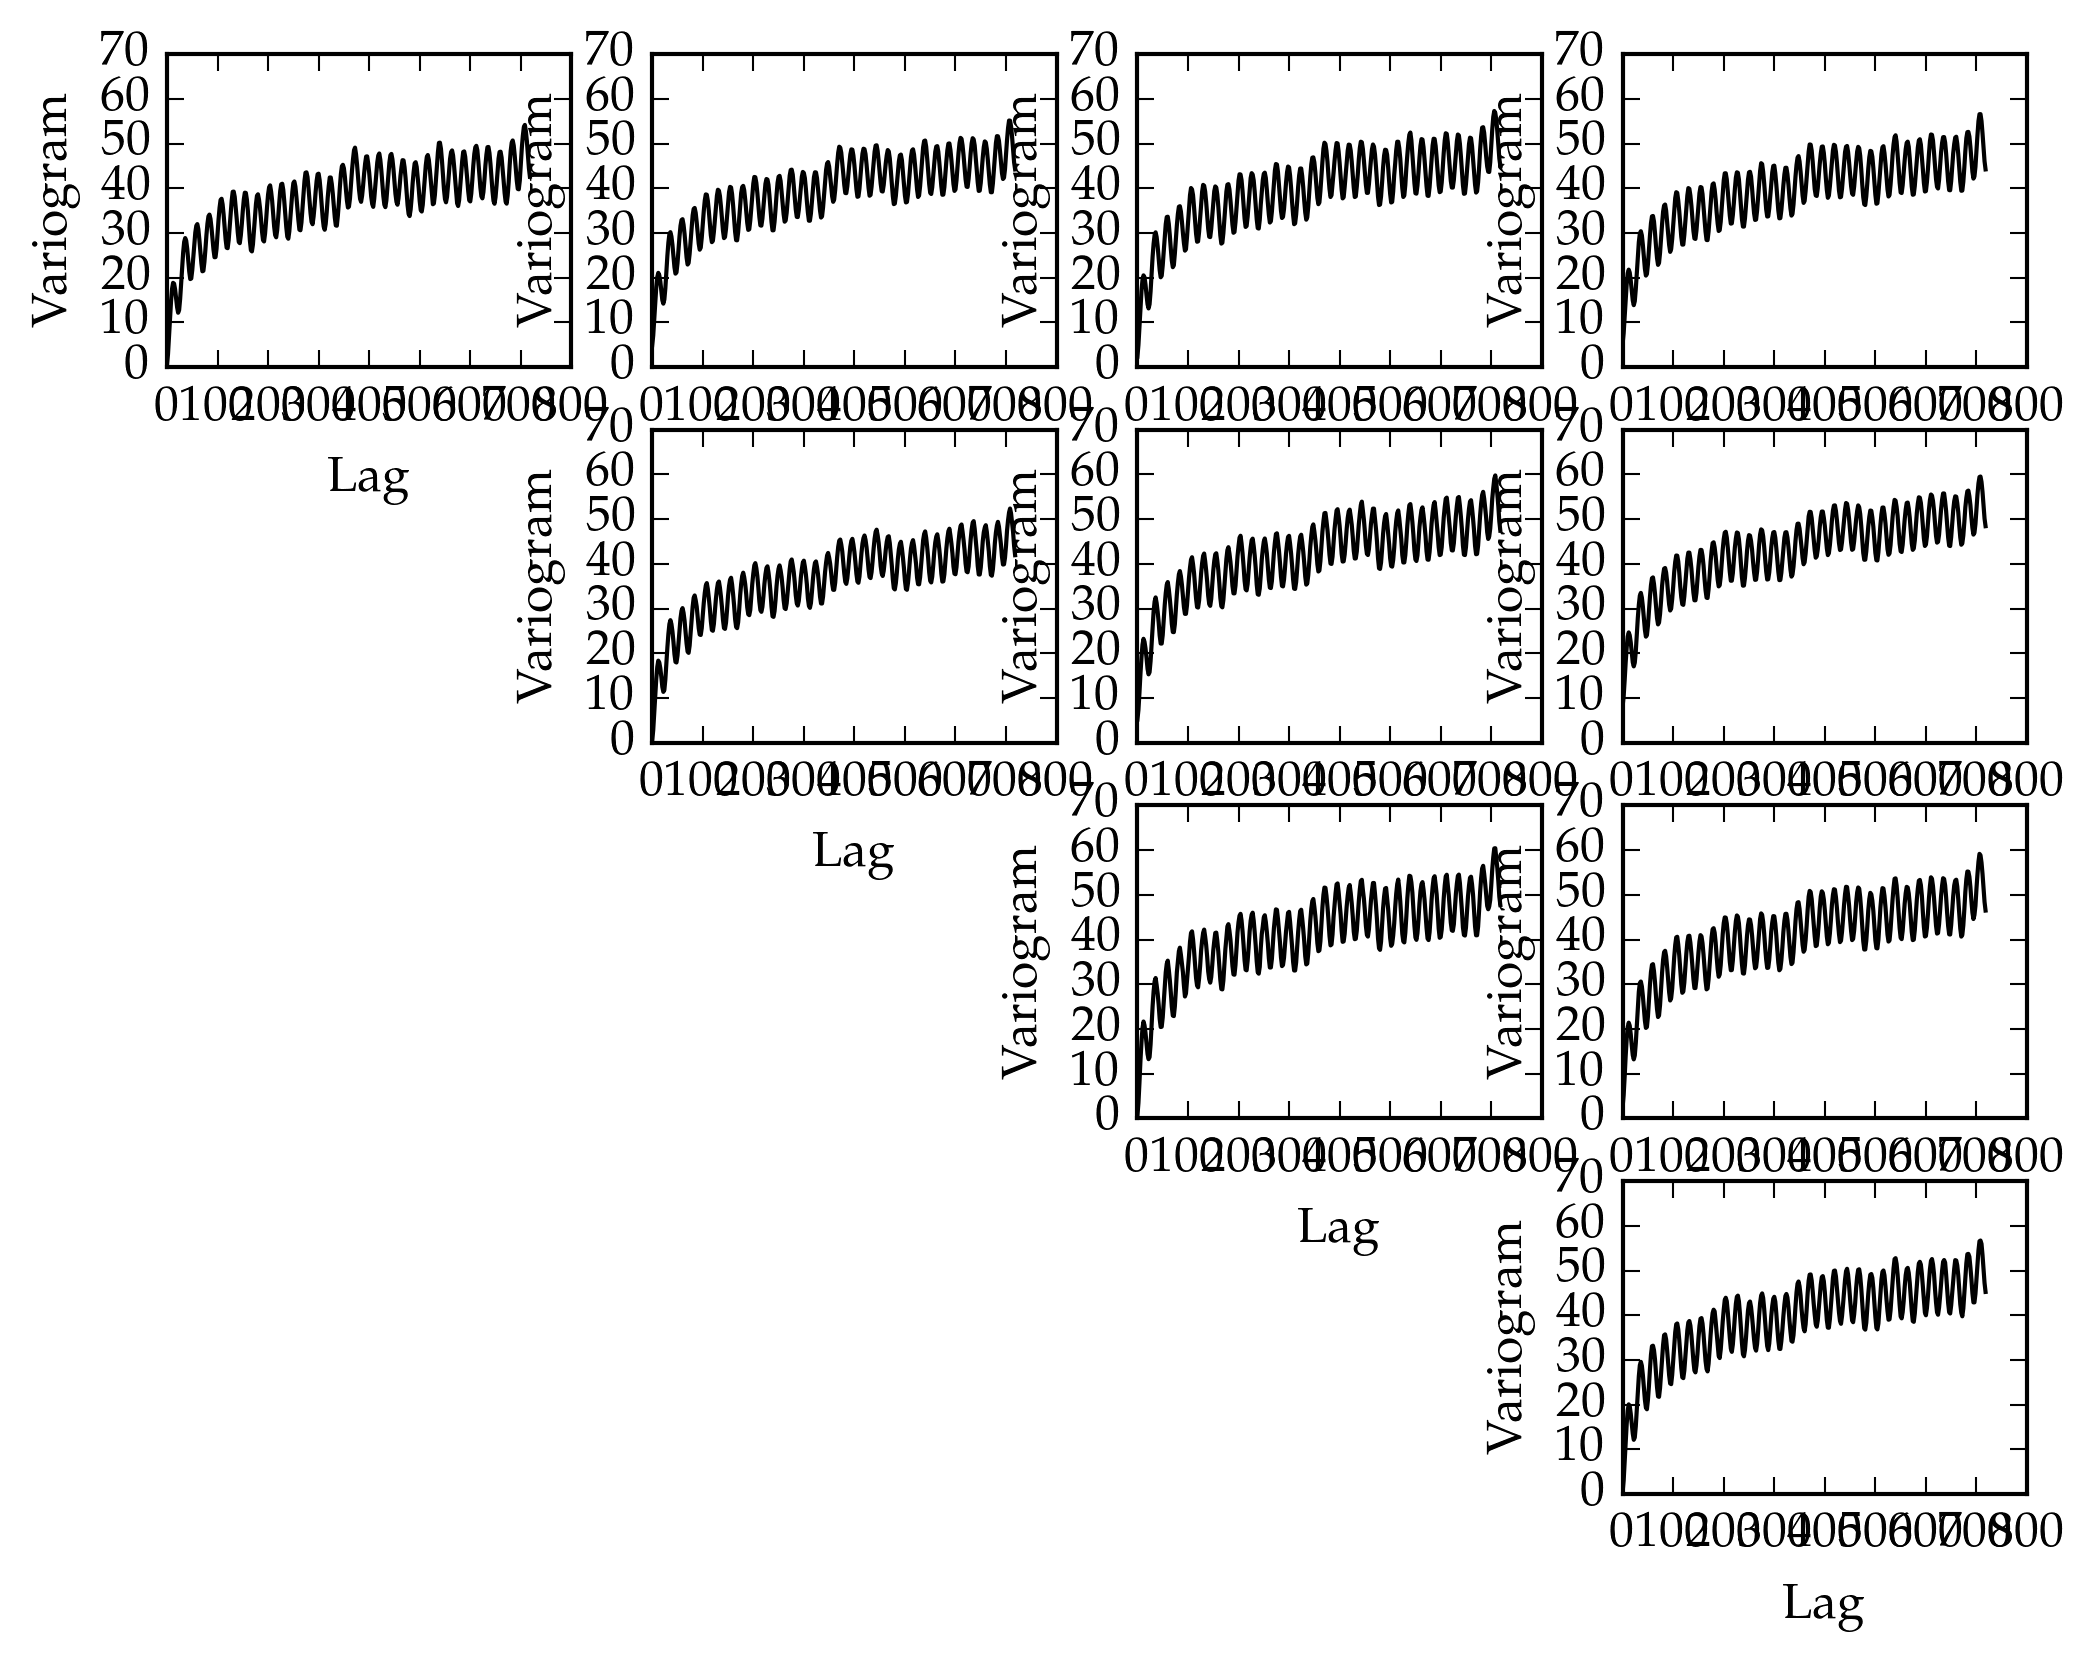

In [31]:
for station_i in 1:4
    for station_j in station_i:4
        v=all_cross_variogs[station_i,station_j]
        plt.subplot(4,4,(station_i-1)*4+station_j)

        y = variog(v)
        x = convert(Vector{Float64},v.bins)
        plt.plot(x, y, color="black")
        plt.xlabel("Lag")
        plt.ylabel("Variogram")
        plt.ylim(0,70)
    end
end

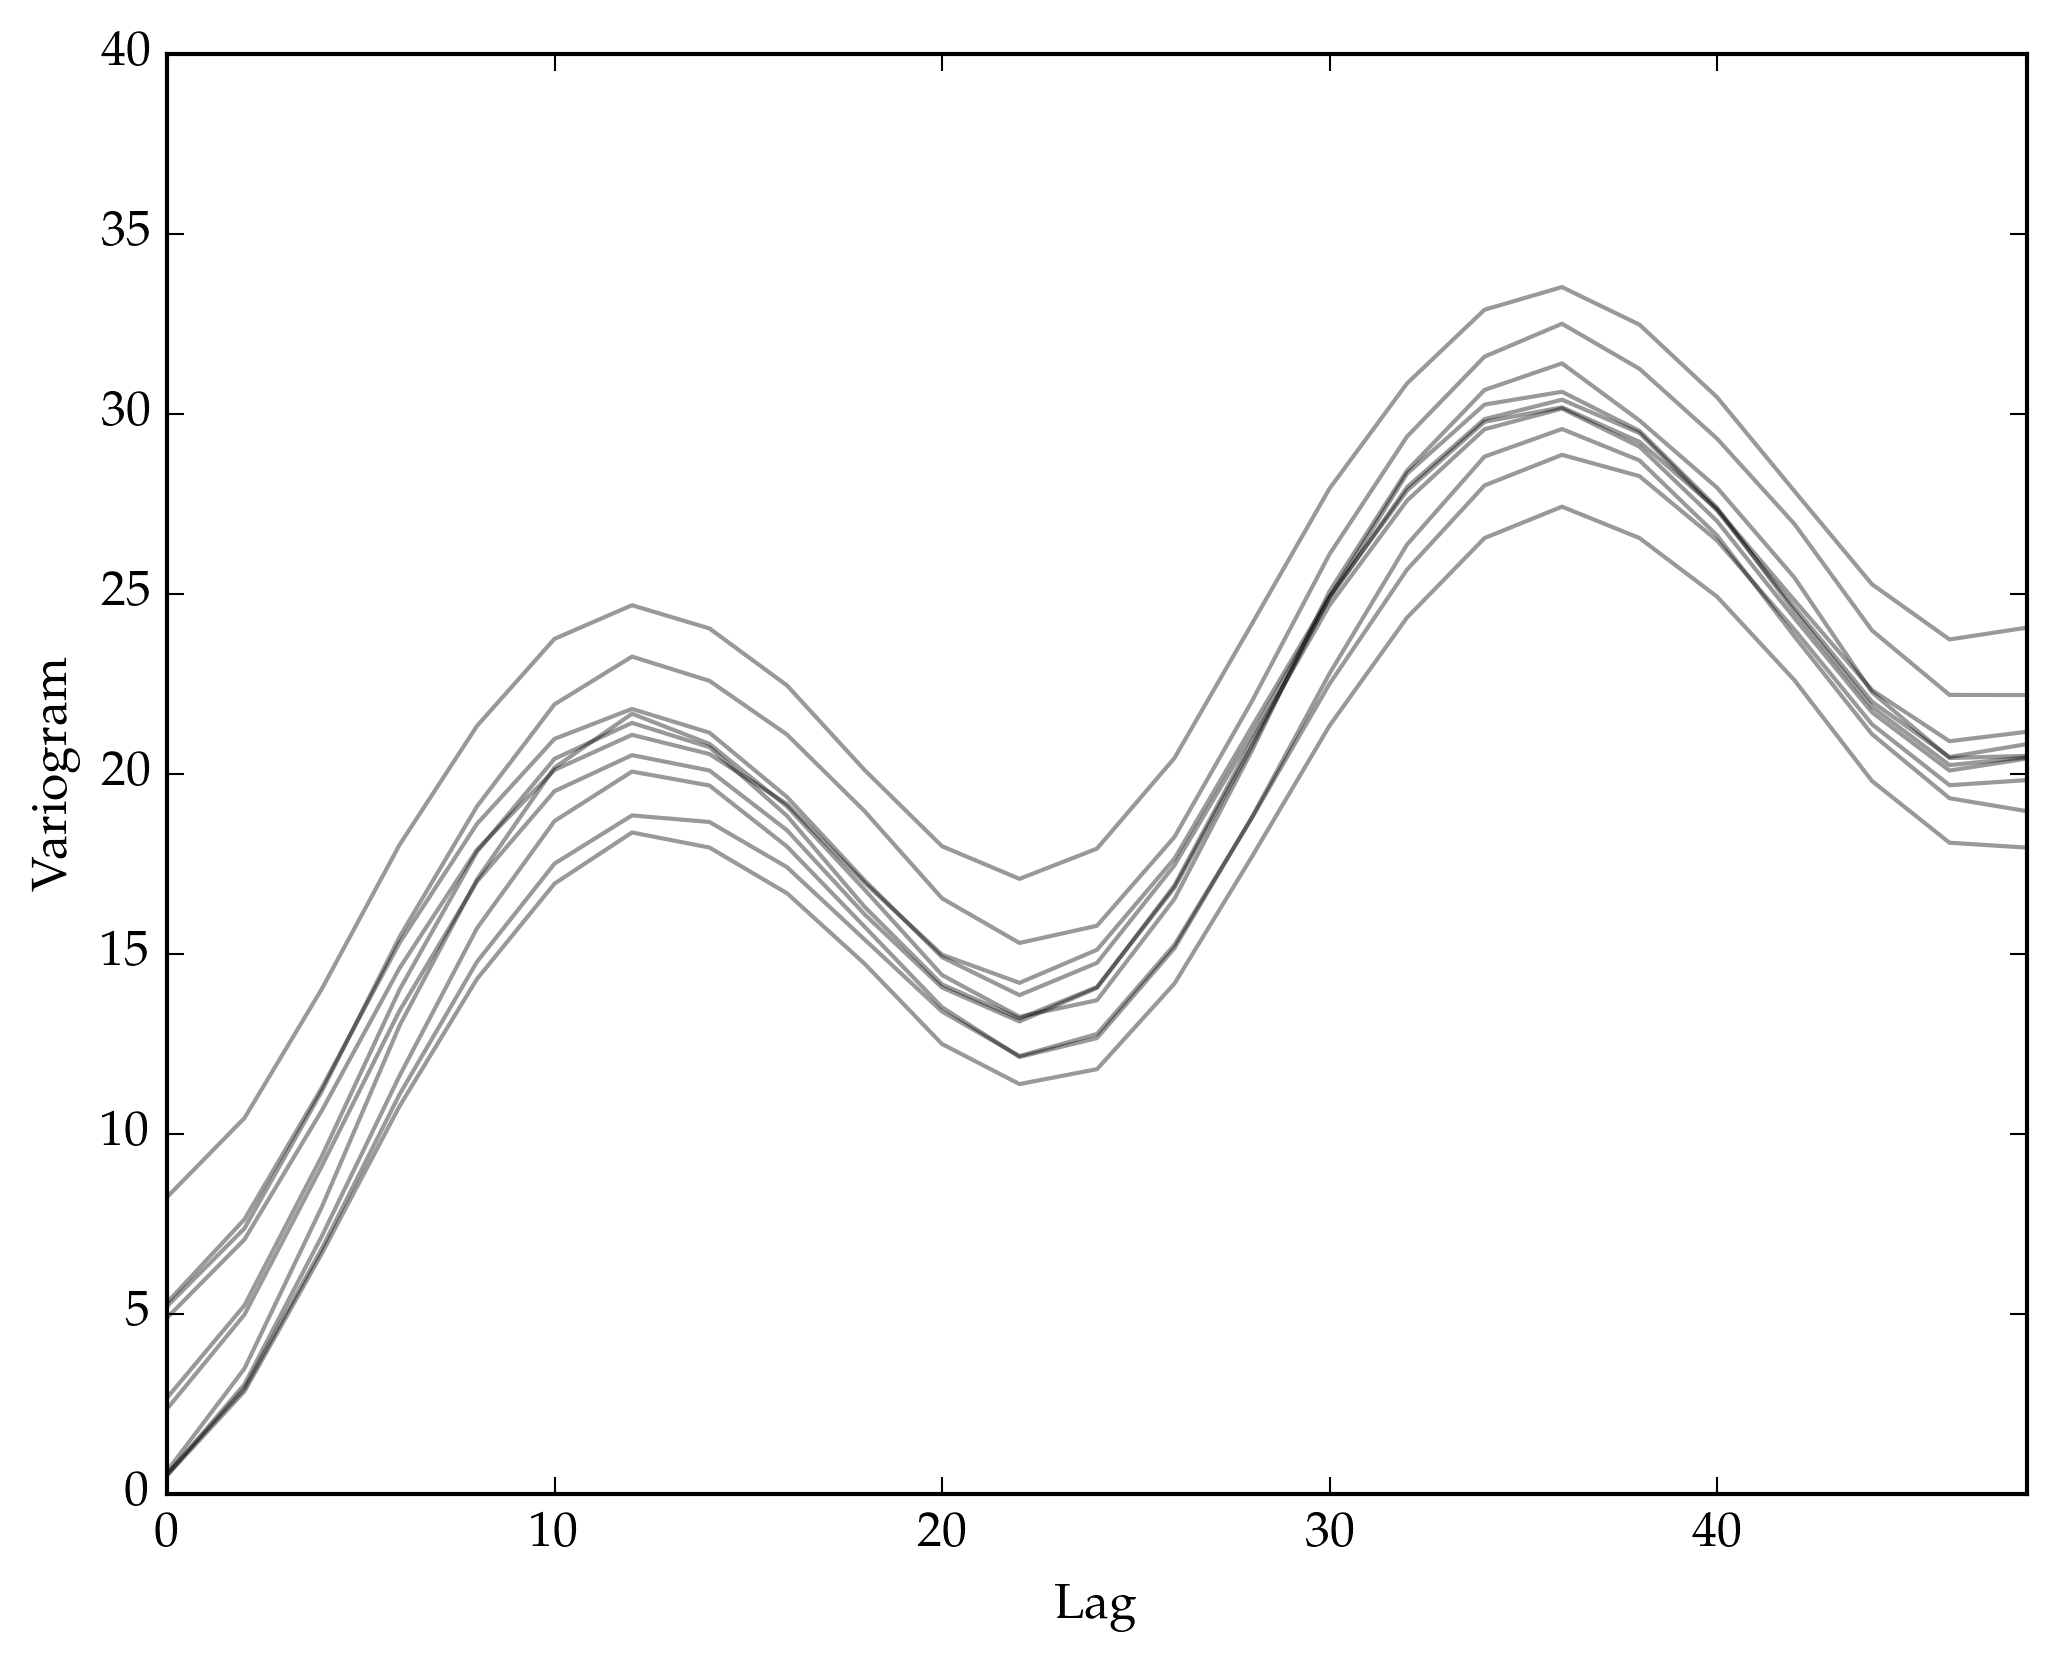

(0,40)

In [35]:
for station_i in 1:4
    for station_j in station_i:4
        v=all_cross_variogs[station_i,station_j]
        y = variog(v)
        x = convert(Vector{Float64},v.bins)
        plt.plot(x, y, color="black", alpha=0.4)
        plt.xlabel("Lag")
        plt.ylabel("Variogram")
    end
end
plt.xlim(0,48)
plt.ylim(0,40)